Notes:

1. Using jeremy's model with tf-idf put me at 0.52 on public leaderboard
2. Using the best tfidf and nbsvm hyperparameters for each label put me at 0.51 on public LB

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai.imports import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_STOPWORDS
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud, STOPWORDS

import gc
from scipy import sparse

# pandas and plotting config
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)

In [4]:
PATH = 'data/toxic-comments'

os.makedirs(f'{PATH}/models', exist_ok=True)

## Examine the data

In [5]:
raw_train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

Let's look at the dataset sizes and for the ratio or train-to-test examples

In [6]:
n_train_sz, n_test_sz = len(raw_train_df), len(test_df)
n_total = n_train_sz + n_test_sz

print('\tTrain\tTest')
print(f'Size:\t{n_train_sz} | {n_test_sz}')
print(f'%:\t{round(n_train_sz / n_total, 2)}   | {round(n_test_sz / n_total, 2)}')

raw_train_df.head()


	Train	Test
Size:	95851 | 226998
%:	0.3   | 0.7


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true. I'll have your account terminated.",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you did with this edit to W. S. Merwin. If you continue to do so, you will be blocked from editing. """,0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the """"points of interest"""" section you added because it seemed kind of spammy. I know you probably didn't mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That's just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage. """,0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offence. Wow wasn't aware of it. Blocking me has shown your support towards your community. Thanku for that,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ethereal vocal style and dark lyrical content. The cited sources in the External Links are saying those things. If you feel the sources are unreliable or I did not represent what they said correctly rewrite or delete it.,0,0,0,0,0,0


There is a 30/70 train/test split

Let's look at the summary for each dataset.  In particular, we want to address missing values and any other cleanup

In [7]:
display(DataFrameSummary(raw_train_df).summary())
display(DataFrameSummary(test_df).summary())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,95851,NaN,95851,95851,95851,95851,95851,95851
mean,4.99436e+11,NaN,0.0963683,0.0100677,0.0533015,0.00318202,0.0497126,0.00849235
std,2.89014e+11,NaN,0.295097,0.0998321,0.224635,0.0563199,0.217352,0.0917623
min,2.22566e+07,NaN,0,0,0,0,0,0
25%,2.47344e+11,NaN,0,0,0,0,0,0
50%,5.0013e+11,NaN,0,0,0,0,0,0
75%,7.50109e+11,NaN,0,0,0,0,0,0
max,9.99988e+11,NaN,1,1,1,1,1,1
counts,95851,95851,95851,95851,95851,95851,95851,95851
uniques,95851,95851,2,2,2,2,2,2


,id,comment_text
count,226998,NaN
mean,5.00498e+11,NaN
std,2.8865e+11,NaN
min,6.04486e+06,NaN
25%,2.50777e+11,NaN
50%,5.0092e+11,NaN
75%,7.50354e+11,NaN
max,9.99998e+11,NaN
counts,226998,226997
uniques,226998,226997


There is a missing value in test dataset that we will need to address.

Look at comment length and number of words.

In [8]:
print('Train')
comment_len = raw_train_df.comment_text.str.len()
print(f'Length:\tmean: {comment_len.mean():.2f}\t|\tstd: {comment_len.std():.2f}\t|\tmax: {comment_len.max()}')

n_words = raw_train_df.comment_text.str.split().str.len()
print(f'Words:\tmean: {n_words.mean():.2f}\t|\tstd: {n_words.std():.2f}\t|\tmax: {n_words.max()}')

print('-----------------------------------')
print('Test')
comment_len_test = test_df.comment_text.str.len()
print(f'Length:\tmean: {comment_len_test.mean():.2f}\t|\tstd: {comment_len_test.std():.2f}\t|\tmax: {comment_len_test.max()}')

n_words = test_df.comment_text.str.split().str.len()
print(f'Words:\tmean: {n_words.mean():.2f}\t|\tstd: {n_words.std():.2f}\t|\tmax: {n_words.max()}')

Train
Length:	mean: 395.34	|	std: 595.10	|	max: 5000
Words:	mean: 67.42	|	std: 99.81	|	max: 1403
-----------------------------------
Test
Length:	mean: 473.78	|	std: 4445.61	|	max: 2003165.0
Words:	mean: 73.76	|	std: 235.55	|	max: 58515.0


The length varies a lot: **the standard deviation** ... is a measure that is used to quantify the amount of variation or dispersion of a set of data values. A standard deviation close to 0 indicates that the data points tend to be very close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.

There is a comment in the test set with over 2 million characters!

Let's limit the number of characters to the max. found in the training dataset and also fill any nulls (re-run the above after this).  We will also fill in any nulls with 'unknown'

In [9]:
test_df.comment_text = test_df.comment_text.str[0:5000]

raw_train_df.comment_text.fillna("unknown", inplace=True)
test_df.comment_text.fillna("unknown", inplace=True)

Let's look at the class distribution

Define the labels we want to predict including a "None" label for those comments with 0's for each label

In [10]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
raw_train_df['none'] = 1 - raw_train_df[label_cols].max(axis=1)

In [11]:
value_counts_df = raw_train_df[label_cols + ['none']].apply(pd.Series.value_counts)
display(value_counts_df)

n_clean = value_counts_df.loc[1, "none"]
n_toxic = value_counts_df.loc[0, "none"]
p_toxic = round(n_toxic / len(raw_train_df), 2)
toxic_to_clean_ratio = round(n_toxic / n_clean, 2)

print(f'# of clean comments: {n_clean}')
print(f'# of unclean comments: {n_toxic}')
print(f'% unclean comments: {p_toxic}')
print(f'Ratio of toxic comments: {toxic_to_clean_ratio}')

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,86614,94886,90742,95546,91086,95037,9790
1,9237,965,5109,305,4765,814,86061


# of clean comments: 86061
# of unclean comments: 9790
% unclean comments: 0.1
Ratio of toxic comments: 0.11


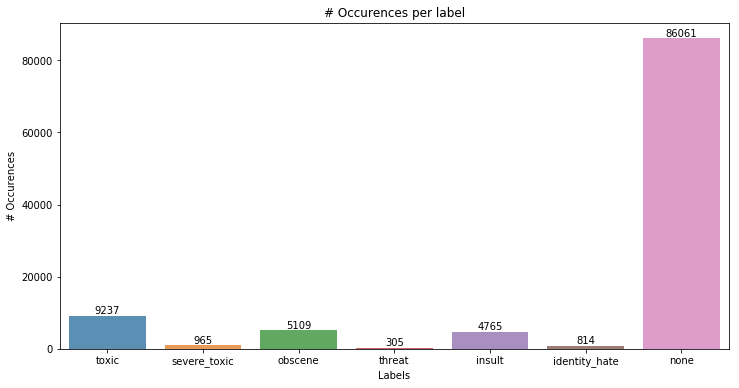

In [12]:
x = value_counts_df.iloc[1,:]

plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('# Occurences per label')
plt.ylabel('# Occurences')
plt.xlabel('Labels')

rects = ax.patches
labels = x.values

for rect, lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, lbl, ha='center', va='bottom')
    
plt.show()

There is definitely a class imbalance.

Let's see to what degree comments are tagged with multiple labels

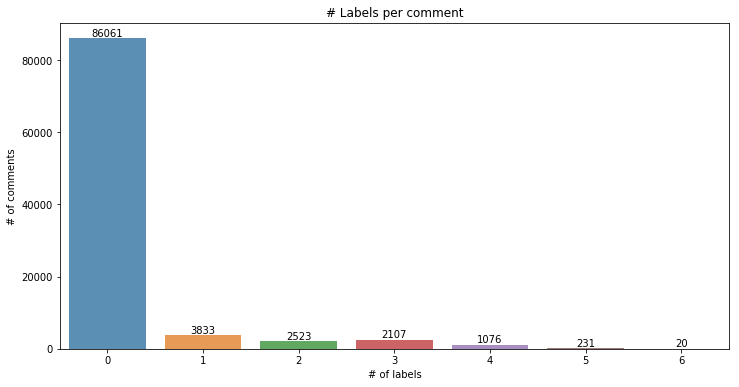

In [13]:
mult_labels_s = raw_train_df[label_cols].sum(axis=1).value_counts()
# display(mult_labels_s)

x = mult_labels_s

plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title('# Labels per comment')
plt.ylabel('# of comments')
plt.xlabel('# of labels')

rects = ax.patches
labels = x.values

for rect, lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, lbl, ha='center', va='bottom')
    
plt.show()

So we see that:
* ~ 10% of the comments are toxic
* ~ 66% of the toxic 9,790 comments are multi-labeled

Let's look at how these labels are correlated

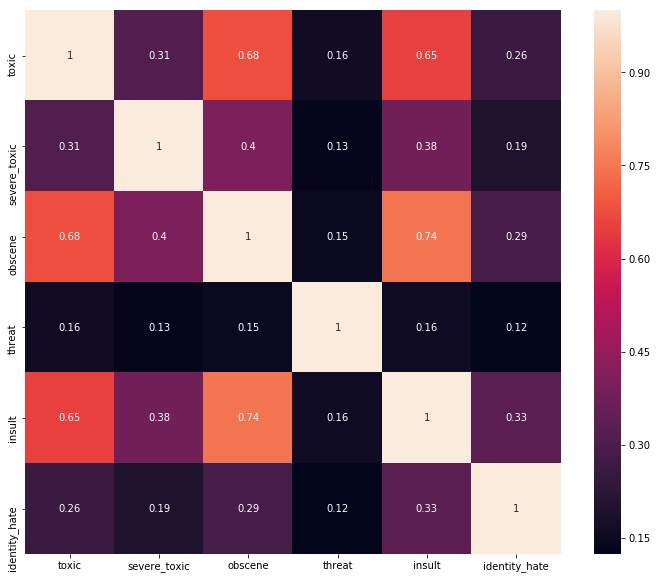

In [14]:
corr_df = raw_train_df[label_cols].corr()
# display(corr_df)

plt.figure(figsize=(12,10))
sns.heatmap(corr_df, xticklabels=corr_df.columns.values, yticklabels=corr_df.columns.values, annot=True)

We see the following correlations:
* Toxic + Obscene
* Toxic + Insult
* Obscene + Insult

Examples of each

In [15]:
for lbl in label_cols:
    ex = raw_train_df[raw_train_df[lbl] == 1].comment_text.iloc[10]
    print(f'{lbl}:\n{ex}\n-----------------------\n')

toxic:
HE THINKS THEY ARE COPYRIGHT VIOLATION. PITY HIM, HE IS SICKO!
-----------------------

severe_toxic:
Fuck Wikipedia and fuck all the leftist, liberal, faggot-loving Jew Communists that run this fucked up piece of shit website!
-----------------------

obscene:
is the sock puppet of ,fuck off
-----------------------

threat:
Wow dude.  As your physician I suggest you slit your wrists.
-----------------------

insult:
These Iranian bastards are at it again. Not only here, but also in the German Wikipedia. User:Tajik's German account, de:Benutzer:Phoenix2, is falsifying and misquoting sources. You need to watch his IPs! These Iranian faggots won't give up! Keep Rumi, Safavids, and Babak on your watchlist.
-----------------------

identity_hate:
If you guys really discuss napoleon you need to get a fuckin life. it is so sad that you would rather discuss someone who has been dead for years then to look at porn.YOU GUYS R HOMOSEXUALS LIKE ANAL SEX TYPES
-----------------------



Wordclouds - Frequent Words for each label

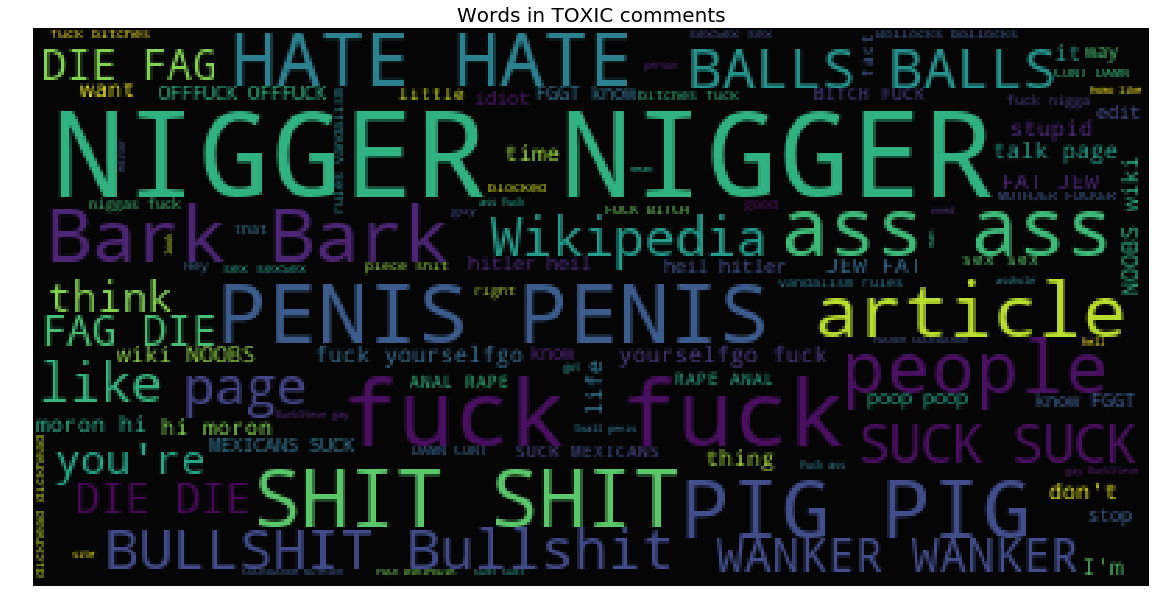

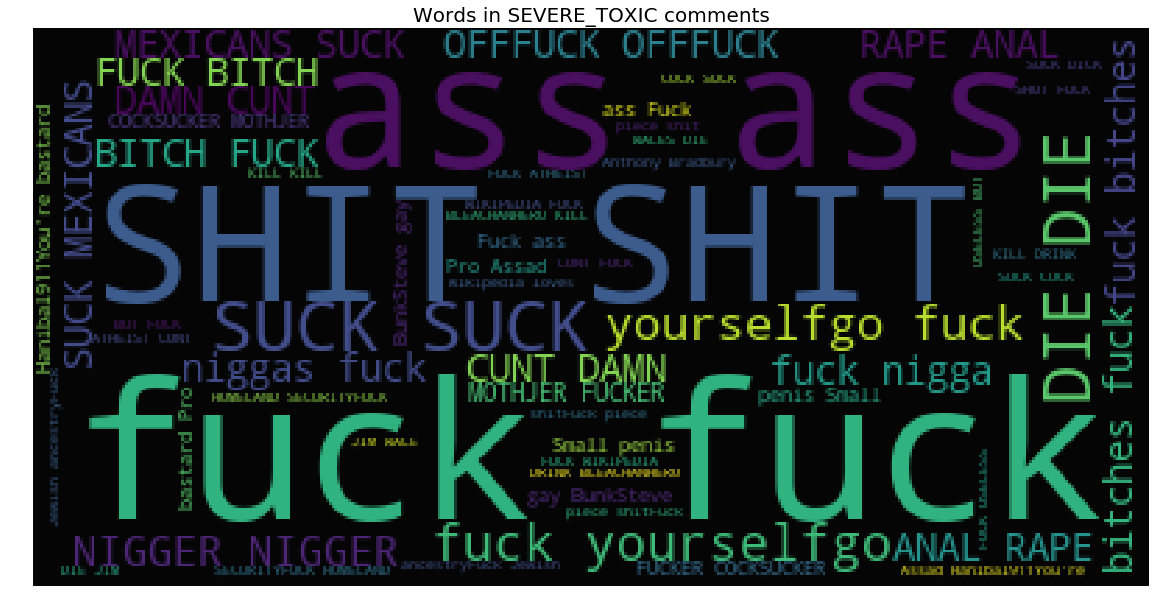

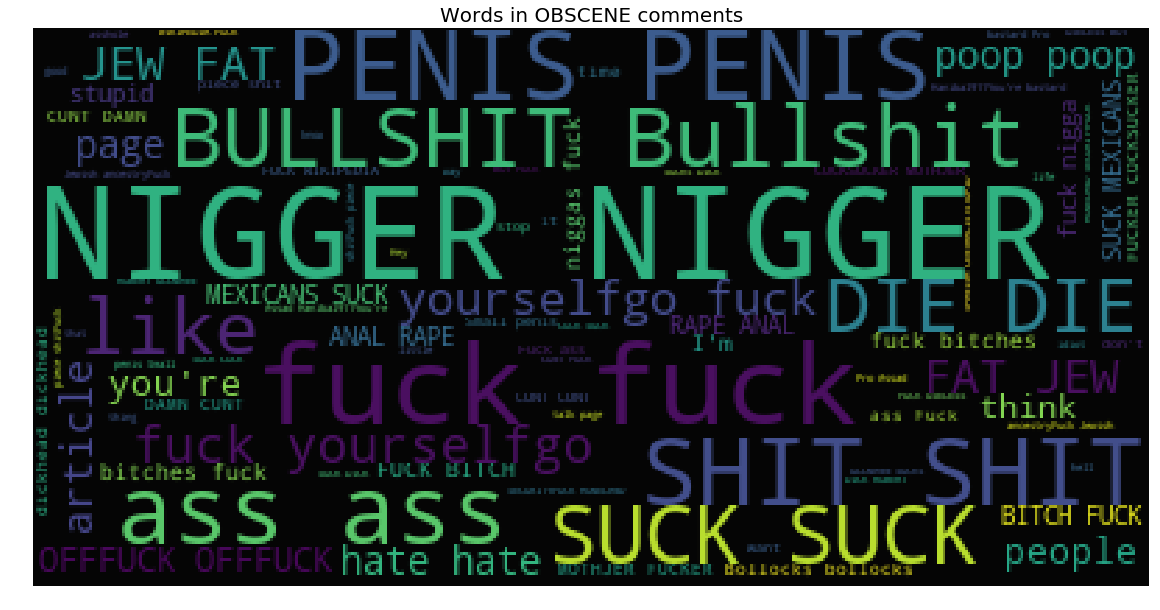

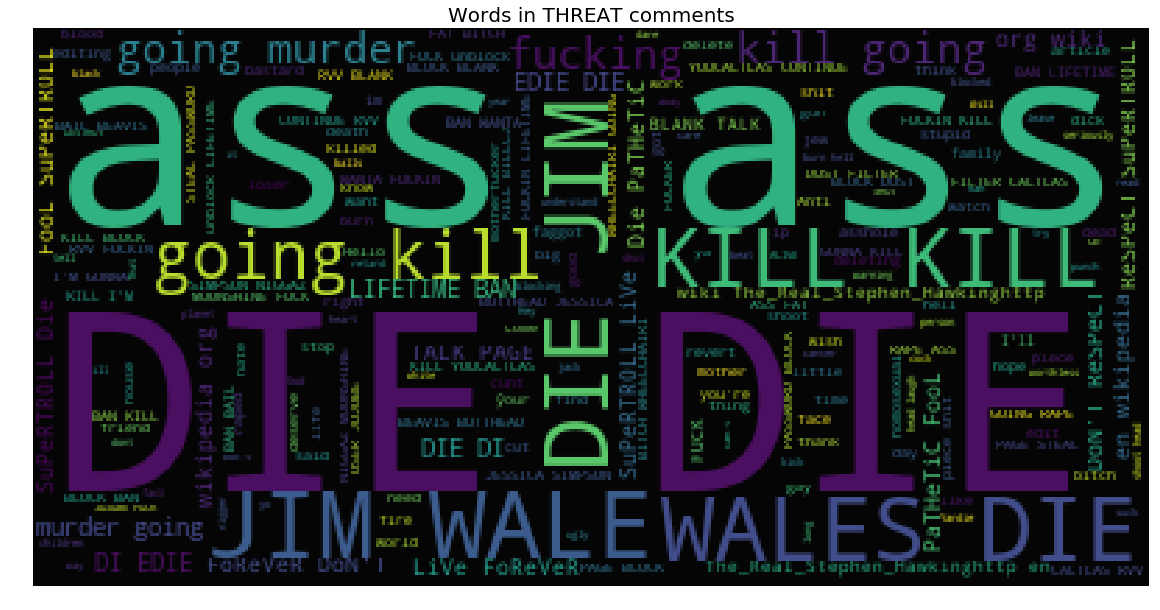

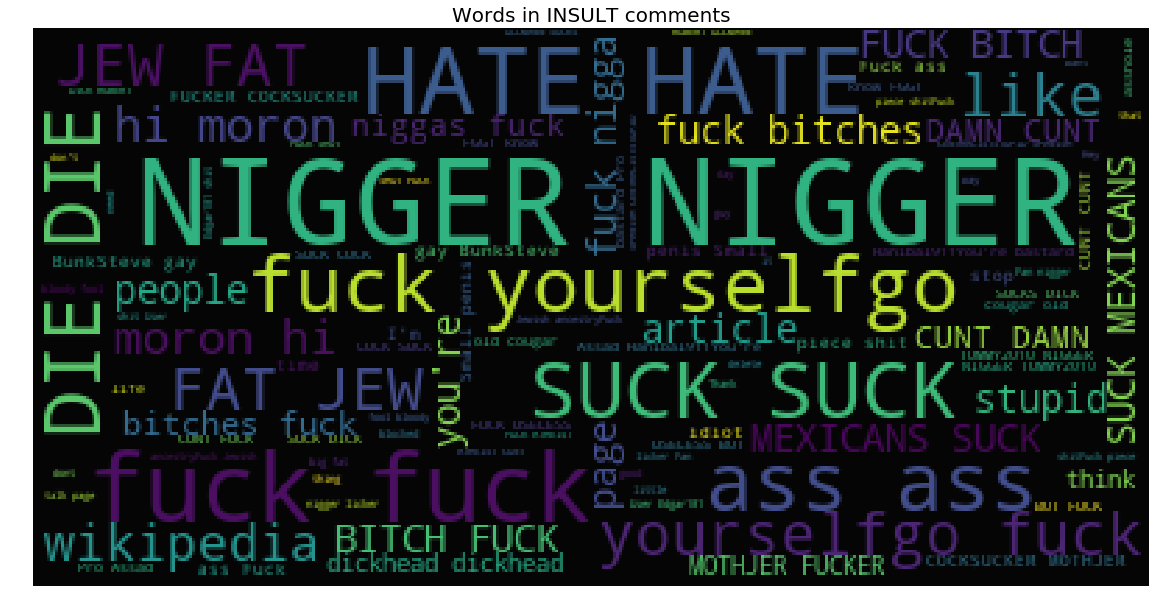

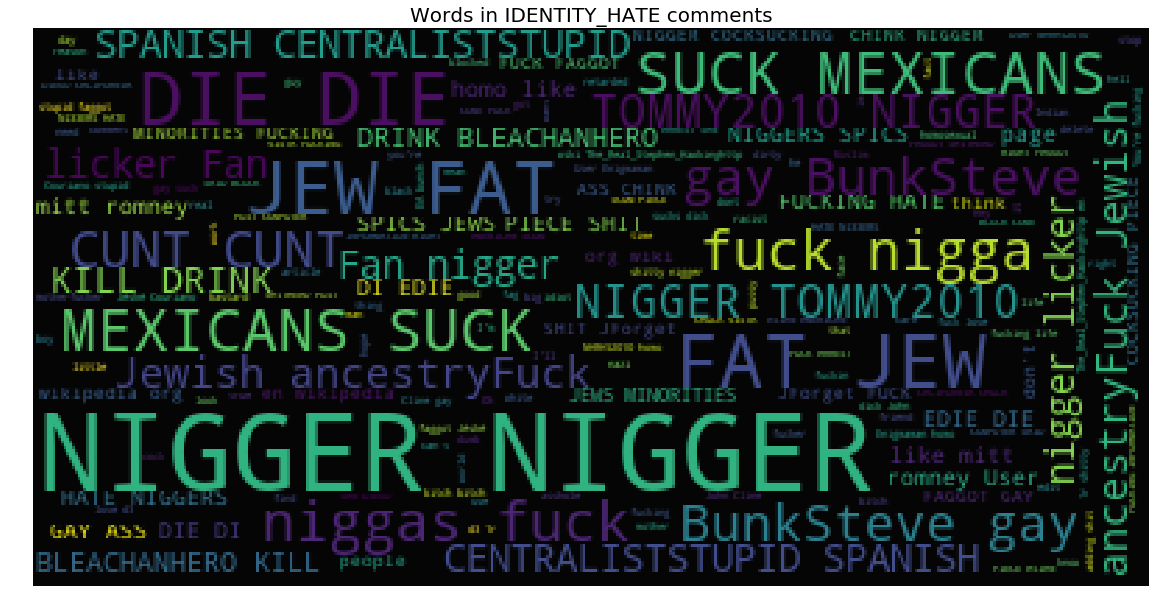

In [27]:
for lbl in label_cols:
    df = raw_train_df[raw_train_df[lbl] == 1]
    txt = df.comment_text.values
    
    wc = WordCloud(background_color='black', max_words=4000, stopwords=spacy_STOPWORDS)
    wc.generate(' '.join(txt))
    
    plt.figure(figsize=(20,14))
    plt.axis('off')
    plt.title(f'Words in {lbl.upper()} comments', fontsize=20)
    plt.imshow(wc.recolor(colormap='viridis', random_state=42), alpha=0.98)
    plt.show()

### Feature Engineering

#### Direct Features
Features which describe the documents
* Word Frequency (unigrams, bigrams, trigrams)
* Vector distances using embeddings (e.g., Glove, Word2Vec, custom)
* Sentiment scores

#### Indirect Features
Experimental additions used to describe the makeup of the documents
* Count of words
* Count of unique words
* Count of letters
* Count of uppercase words and characters
* Count of puncutaions
* Count of stop words

#### Leaky Features
From the wordclouds and examples we know that comments contain identifier information (e.g., IP addresses, usernames, etc...).  We can create features out of them but that will likely lead to **overfitting**
* Toxic IP scores
* Toxic Users

*Note*: We create the indirect and leaky features FIRST since we only want to get counts of a cleaned corpus.

List the unique characters in this dataset

In [28]:
chars = sorted(list(set(raw_train_df.comment_text.str.cat(sep=' '))))
''.join(chars)

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~\x93\x94\x95\x97\x99\x9d\xa0¡¢£¤¥¦§¨©ª«¬\xad®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿĀāĂăĄąĆćĈĉĊċČčĎďĐđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĴĵĶķĹĺĻļĽľĿŀŁłŃńŅņŇňŋŌōŎŏŐőŒœŔŕŖŗŘřŚśŜŝŞşŠšŢţŤťŦŨũŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžƏƒơưǀǁǂǃǌǍǎǏǐǑǒǓǔǖǘǚǜǝǢǣǧǪǫǰȋȗșțȲȳɐɑɒɓɔɕɖɗɘəɚɛɜɝɞɟɠɡɢɣɤɥɦɧɨɩɪɫɬɭɮɯɰɱɲɳɴɵɶɸɹɺɻɽɾɿʀʁʂʃʄʇʈʉʊʋʌʍʎʏʐʑʒʔʕʘʙʛʜʝʞʟʡʢʨʰʲʷʻʼʿˀˁˈˉˌːˑ˜ˠˡˤ˺̗̜̞̥̩̪̫̭̮̯̰̲̹̺̼͇͉͍͓͖͙͚́̂̃̄̆̈̉̎̓̿͑ͤͧͨͩͮ͡ΆΈΉΊΌΎΏΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩάέήίαβγδεζηθικλμνξοπρςστυφχψωόύώϾЁЂЃЄЅІЇЈЉЊЋЌЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёђѓєѕіїјљњћќўџѧ҅҈ҐґҝүӢӧՇՈագթիմյնշոտրւְֲִֶַָֻּ׀ׁאבגדהוזחטיךכלםמןנסעפץצקרשת״،ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىئًُّپچڜکڬڰڵہی\u06dd۞۩۬۵۸ۻ۾ݓݗݜݟݡݣݭ߷ँंअइउऋकगघजझटणतथदधनपफभमरलवशषसह़ािीुूॆेो्ॐ१२३४५६७८९ংঅইকজটতদনবভমযরলসহ়ািুেো্৳ਖਜਨਫਮਰਸ਼ਾੁ੭અદનવાુ୯அஆஇஉஎஒகஙசஜடணதநனபமயரறலளழவாிீுெேைொோ்అదనవాుಅದನವಾುംകടദമരവസാെോ്කතඳරව්ුกคตปมยรลวอาุ฿แ่๛ກນປພສາແ༆࿓აგევთილმნოპრსფღხትው

Some feature engineering that may be helpful

In [51]:
def add_cols(df, txt_col='text'):
    rows = []
    
    for index, row in df.iterrows():
        cols = OrderedDict({
            'token_count': 0.0,
            'named_entity_count': 0.0,
            'word_count': 0.0,
            'unique_word_count': 0.0,
            'unique_word_pct': 0.0,
            'upper_word_count': 0.0,
            'avg_word_len': 0.0,
            'char_count': 0.0,
            'unique_char_count': 0.0,
            'upper_char_count': 0.0,
            
            'stopwords_count': 0.0,
            'punctuation_count': 0.0,
            'punctuation_pct': 0.0,
            'symbol_count': 0.0,
            'number_count': 0.0,
            'alpha_count': 0.0,
            'noun_count': 0.0,
            'verb_count': 0.0,
            'adj_count': 0.0,
            'proper_name_count': 0.0,

            # named entity types
            'named_entity_count': 0.0,
            'named_entity_person_count': 0.0,
            'named_entity_norp_count': 0.0,
            'named_entity_facility_count': 0.0,
            'named_entity_org_count': 0.0,
            'named_entity_gpe_count': 0.0,
            'named_entity_non_gpe_loc_count': 0.0,
            'named_entity_product_count': 0.0,
            'named_entity_event_count': 0.0,
            'named_entity_woa_count': 0.0,
            'named_entity_lang_count': 0.0,
            'named_entity_date_count': 0.0,
            'named_entity_time_count': 0.0,
            'named_entity_money_count': 0.0,
            'named_entity_quantity_count': 0.0
        })
        
        # grab tokens, entities, and word tokens
        txt = row[txt_col]
        tokens = nlp(txt)
        ents = tokens.ents
        words = txt.split()
        
        # get counts
        cols['token_count'] = len(tokens)
        cols['ent_count'] = len(ents)
        cols['word_count'] = len(words)
        cols['unique_word_count'] = len(set(words))
        cols['upper_word_count'] = len([w for w in words if (w.isupper())])
        cols['avg_word_len'] = np.mean([len(w) for w in words])
        
        cols['char_count'] = len(txt)
        cols['unique_char_count'] = len(set(txt))
        cols['upper_char_count'] = len([c for c in txt if (c.isupper())])
        
        for t in tokens:
            if (t.is_punct): cols['punctuation_count'] += 1
            if (t.is_stop): cols['stopwords_count'] += 1
            if (t.pos_ == 'SYM'): cols['symbol_count'] += 1
            if (t.pos_ == 'NUM'): cols['number_count'] += 1
            if (t.is_alpha): cols['alpha_count'] += 1
                
            if (t.pos_ == 'NOUN') : cols['noun_count'] += 1
            if (t.pos_ == 'VERB') : cols['verb_count'] += 1
            if (t.pos_ == 'ADJ') : cols['adj_count'] += 1
            if (t.pos_ == 'PROPN') : cols['proper_name_count'] += 1
                
        for ent in ents:
            if (ent.label_ == 'PERSON'): cols['proper_name_count'] += 1
            if (ent.label_ == 'NORP'): cols['named_entity_norp_count'] += 1
            if (ent.label_ == 'FACILITY'): cols['named_entity_facility_count'] += 1
            if (ent.label_ == 'ORG'): cols['named_entity_org_count'] += 1
            if (ent.label_ == 'GPE'): cols['named_entity_gpe_count'] += 1
            if (ent.label_ == 'LOC'): cols['named_entity_non_gpe_loc_count'] += 1
            if (ent.label_ == 'PRODUCT'): cols['named_entity_product_count'] += 1
            if (ent.label_ == 'EVENT'): cols['named_entity_event_count'] += 1
            if (ent.label_ == 'WORK_OF_ART'): cols['named_entity_woa_count'] += 1
            if (ent.label_ == 'LANGUAGE'): cols['named_entity_lang_count'] += 1
            if (ent.label_ == 'DATE'): cols['named_entity_date_count'] += 1
            if (ent.label_ == 'TIME'): cols['named_entity_time_count'] += 1
            if (ent.label_ == 'MONEY'): cols['named_entity_money_count'] += 1
            if (ent.label_ == 'QUANTITY'): cols['named_entity_quantity_count'] += 1

        cols['unique_word_pct'] = (cols['unique_word_count'] + 1) / (cols['word_count'] + 1)
        cols['unique_char_pct'] = (cols['unique_char_count'] + 1) / (cols['char_count'] + 1)
        cols['punctuation_pct'] = (cols['punctuation_count'] + 1) / (cols['token_count'] + 1)
        
        rows.append(cols)
        
    return pd.DataFrame(rows, columns=cols.keys())

In [52]:
%time raw_train_df = pd.concat([raw_train_df, add_cols(raw_train_df, 'comment_text')], axis=1)
print('train done ...')

%time test_df = pd.concat([test_df, add_cols(test_df, 'comment_text')], axis=1)
print('test done ...')

CPU times: user 1h 28min 2s, sys: 45.2 s, total: 1h 28min 47s
Wall time: 22min 29s
train done ...
CPU times: user 3h 36min 32s, sys: 1min 51s, total: 3h 38min 24s
Wall time: 55min 21s
test done ...


In [53]:
raw_train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,token_count,named_entity_count,word_count,unique_word_count,unique_word_pct,upper_word_count,avg_word_len,char_count,unique_char_count,upper_char_count,stopwords_count,punctuation_count,punctuation_pct,symbol_count,number_count,alpha_count,noun_count,verb_count,adj_count,proper_name_count,named_entity_person_count,named_entity_norp_count,named_entity_facility_count,named_entity_org_count,named_entity_gpe_count,named_entity_non_gpe_loc_count,named_entity_product_count,named_entity_event_count,named_entity_woa_count,named_entity_lang_count,named_entity_date_count,named_entity_time_count,named_entity_money_count,named_entity_quantity_count,ent_count,unique_char_pct
0,22256635,"Nonsense? kiss off, geek. what I said is true. I'll have your account terminated.",1,0,0,0,0,0,0,22,0.0,14,14,1.000000,1,4.857143,83,27,3,5.0,5.0,0.260870,0.0,0.0,14.0,4.0,6.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.333333
1,27450690,"""\n\n Please do not vandalize pages, as you did with this edit to W. S. Merwin. If you continue to do so, you will be blocked from editing. """,0,0,0,0,0,0,1,35,0.0,29,24,0.833333,2,3.758621,142,33,5,16.0,6.0,0.194444,0.0,0.0,25.0,3.0,8.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.237762
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the """"points of interest"""" section you added because it seemed kind of spammy. I know you probably didn't mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That's just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage. """,0,0,0,0,0,0,1,96,0.0,69,54,0.785714,2,4.869565,411,39,6,34.0,23.0,0.247423,0.0,0.0,66.0,14.0,14.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.097087
3,77493077,Asking some his nationality is a Racial offence. Wow wasn't aware of it. Blocking me has shown your support towards your community. Thanku for that,0,0,0,0,0,0,1,30,0.0,25,24,0.961538,0,4.920000,148,28,5,14.0,3.0,0.129032,0.0,0.0,25.0,4.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.194631
4,79357270,The reader here is not going by my say so for ethereal vocal style and dark lyrical content. The cited sources in the External Links are saying those things. If you feel the sources are unreliable or I did not represent what they said correctly rewrite or delete it.,0,0,0,0,0,0,1,52,0.0,49,43,0.880000,1,4.448980,266,29,6,23.0,3.0,0.075472,0.0,0.0,49.0,7.0,12.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.112360


In [54]:
raw_train_df.to_csv(f'{PATH}/train_preproc.csv', index=None)
test_df.to_csv(f'{PATH}/test_preproc.csv', index=None)

## 1. Jeremy's NBSVM model

See his kernel here: [NB-SVM strong linear baseline + EDA (0.052 lb)](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb)

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

raw_train_df = pd.read_csv(f'{PATH}/train_preproc.csv')
test_df = pd.read_csv(f'{PATH}/test_preproc.csv')

We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [ ]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

@wg: Using count vectorizer put me at 0.109 on public leaderboard

@wg: Including feature engineered columns made things worse (0.086 on public leaderboard)

In [ ]:
n = raw_train_df.shape[0]

vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1)

# vec = CountVectorizer(ngram_range=(1,2), tokenizer=spacy_tokenizer, 
#                       min_df=3, max_df=0.9, strip_accents='unicode', binary=True)

trn_term_doc = vec.fit_transform(raw_train_df.comment_text)
test_term_doc = vec.transform(test_df.comment_text)

This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

In [ ]:
trn_term_doc, test_term_doc

In [ ]:
X_train = trn_term_doc
X_test = test_term_doc

***optionally*** include feature engineered columns

In [ ]:
train_fe = scipy.sparse.csr_matrix(
                raw_train_df[raw_train_df.columns.drop(['id', 'comment_text', 
                                                        'toxic', 'severe_toxic', 'obscene', 'threat',
                                                        'insult', 'identity_hate', 'none', 'cleaned_text', 
                                                        'lemmatized_text','cleaned_lemmatized_text'])].values)

test_fe = scipy.sparse.csr_matrix(
                test_df[test_df.columns.drop(['id', 'comment_text', 'cleaned_text', 'lemmatized_text',
                                              'cleaned_lemmatized_text'])].values)

# need to convert to csr format .tocsr() to avoid this excpeption when fitting ... 
# "only integer scalar arrays can be converted to a scalar index
X_train = sparse.hstack([X_train, train_fe]).tocsr()
X_test = sparse.hstack([X_test, test_fe]).tocsr()

In [ ]:
raw_train_df[raw_train_df.columns.drop(['id', 'comment_text', 
                                                        'toxic', 'severe_toxic', 'obscene', 'threat',
                                                        'insult', 'identity_hate', 'none', 'cleaned_text', 
                                                        'lemmatized_text','cleaned_lemmatized_text'])].head()

Here's the basic naive bayes feature equation:

In [ ]:
def pr(y_i, y):
    p = X_train[y == y_i].sum(0)              # sum the token counts for each word for the given class "y"
    return (p + 1) / ((y == y_i).sum() + 1)   # token count sums / # of "y" observations

Fit a model, one label at a time

In [ ]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))          # log the ratio of 1 probability to 0 probability
    
    m = LogisticRegression(C=4, dual=True) # use dual=True of term document matrix is wider than tall
    x_nb = X_train.multiply(r)
    
    print(f'X_train.shape = {X_train.shape} | r.shape = {r.shape} | x_nb.shape = {x_nb.shape}')
    
    return m.fit(x_nb, y), r               # return "r" so can use on validation/test sets

In [ ]:
preds = np.zeros((len(test_df), len(label_cols)))

for i, lbl_col in enumerate(label_cols):
    print('fit', lbl_col)
    
    m, r = get_mdl(raw_train_df[lbl_col])
    preds[:,i] = m.predict_proba(X_test.multiply(r))[:,1]

Create submission file

In [ ]:
subm_df = pd.DataFrame({'id': sample_subm_df["id"]})
subm_df = pd.concat([subm_df, pd.DataFrame(preds, columns = label_cols)], axis=1)
subm_df.to_csv(f'{PATH}/nbsvm-jh-tf-fe.csv', index=False)

len(subm_df)

## 2. NBSVM implemented as a custom sklearn classifier

From [NB-SVM strong linear baseline + EDA (0.052 lb)](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316) kernel discussion.

Using this so I can use gridsearch to find the best parameters for both the word vectorizer and classifier for each label.

@wg: This improved my score only fractionaly to 0.051

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# define parameter grid for gridsearch (use `var__attribute` syntax to define step attributes)
params = {
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'vec__min_df': [2, 3],
    'vec__max_df': [0.9, 0.95],
    'vec__use_idf': [True],
    'vec__smooth_idf': [True],
    'vec__sublinear_tf': [True],
    'vec__binary': [True, False],
    'nbsvm__C': [1.0, 4.0, 5.0]
}

pipe = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=tokenize, strip_accents='unicode')),
    ('nbsvm', NbSvmClassifier(dual=True))
])

gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1)

# capture scores for each text column + label combination for evaluation
grid_param_scores = []

for txt_col in ['comment_text', 'cleaned_text', 'lemmatized_text', 'cleaned_lemmatized_text']:
    print(txt_col)
    
    for i, lbl_col in enumerate(label_cols):
        print(f'--- {lbl_col}')
    
        gs.fit(raw_train_df[txt_col], raw_train_df[lbl_col])
    
        gs_params = gs.cv_results_['params']
        gs_mean_scores = gs.cv_results_['mean_test_score']
        gs_std_scores = gs.cv_results_['std_test_score']
        gs_score_ranks = gs.cv_results_['rank_test_score']

        param_scores = [ {
            **params, 
            **{
                'mean_score': m, 
                'std_score': s, 
                'rank_score': r, 
                'txt_col': txt_col,
                'label': lbl_col 
            }
        }
            for params, m, s, r in zip(gs_params, gs_mean_scores, gs_std_scores, gs_score_ranks) ]

        grid_param_scores += param_scores

In [ ]:
param_scores_df = pd.DataFrame.from_dict(grid_param_scores)
param_scores_df.head()

In [ ]:
param_scores_df.to_csv(f'{PATH}/grid_search_results.csv', index=None)

Get the best hyperparameters for each label

In [ ]:
top_scores_df = param_scores_df[(param_scores_df.rank_score == 1) & (param_scores_df.vec__max_df == 0.9)]
top_scores_df.head()

In [ ]:
idxs = top_scores_df.groupby(by=['label'])['mean_score'].transform(max) == top_scores_df.mean_score
top_scores_df[idxs]

Using the best hyperparameters for each label, run the pipeline used in the above gridsearch.

In [ ]:
label_preds = {}

for i, r in top_scores_df[idxs].iterrows():
    pipe_params = {
        'vec__ngram_range': r['vec__ngram_range'],
        'vec__min_df': r['vec__min_df'],
        'vec__max_df': r['vec__max_df'],
        'vec__use_idf': True,
        'vec__smooth_idf': True,
        'vec__sublinear_tf': True,
        'vec__binary': r['vec__binary'],
        'nbsvm__C': r['nbsvm__C']
    }
    
    pipe.set_params(**pipe_params)
    pipe.fit(raw_train_df[r['txt_col']], y=raw_train_df[r['label']])
    
    label_preds[r['label']] = pipe.predict_proba(test_df[r['txt_col']])

In [ ]:
preds = np.zeros((len(test_df), len(label_cols)))

for i, lbl_col in enumerate(label_cols):
    preds[:,i] = label_preds[lbl_col][:,1]

Create submission file

In [ ]:
subm_df = pd.DataFrame({'id': sample_subm_df["id"]})
subm_df = pd.concat([subm_df, pd.DataFrame(preds, columns = label_cols)], axis=1)
subm_df.to_csv(f'{PATH}/nbsvm-jh-tf-best-scores.csv', index=False)

len(subm_df)

## Notes from Jeremy's lecture on NLP:

See ml1/lesson5-nlp notebook | naivebayes.xlsx

```
fastai.nlp import *
from sklearn.linear_model import LogisticRegression
```
/train/neg|pos - a bunch of text files in each of these two directories (based on label)

`trn, trn_y = texts_from_folders(f'{PATH}/train', names)` - will find all folders in path with `names` and create a labeled dataset.  Do the same with test.

#### Terminology and Objectives
Normally the order of the words matters alot, but we are going to throw it away and turn this into a ***term document matrix*** where for each document it contains a list of what words are in it irrespective of ordering.

**Vocabulary** is a list of all the unique words.

**Term Document Matrix** is a *Bag Of Word (BOW)* representation of words.  Is convenient for lineaer models because it gives us a nice matrix we can do math on.

#### Tokenization
In NLP you first have turn your text into a list of words (**tokenization**).  Fastai hasa tokenizer we can use called `tokenize`.

sklearn API is standardized = import, instantiate, fit, transform

`trn_term_doc = veczr.fit_transform(trn)` - will create the vocab and term document matrix based on training set

`val_term_doc = veczr.transform(val)` - will use the previously fitted model (here the previously create vocab) so that the tokens/features are in the same order. 

`trn_term_doc`.shape = documents x tokens

Because most documents don't have all the words, it is stored as a **sparse matrix** which simply stores where the 1's are.  Is more efficient.

You can get the vocabulary by doing `veczr.get_feature_names()`

`veczr.vocabulary_['absurd']` to get an id of a particular word (word-to-integer)

#### Naive Bayes

Start with your TDM

Get the probabilites of each token occuring in each class = *# of times token appears in class / class* (just because you may get a 0 doesn't mean the probability is 0 since we only have a sample so far ... so we add a row of 1's so that every class will at least have 1)

`p(c=pos|doc) = ( P(doc|c=pos) * P(c=pos) ) / P(doc)`

Says ... *What is the probability given a particular document that its class is positive?  NB = probability that we got this particular movie review given that its class is positive multiplied by the probability that any movie review's class is positive ... divided by the probability of getting this particular movie review*

What we really want to know is if it is more likely that this is class 0 or class 1 ...

We want P(c=pos|doc) / P(c=neg|doc) which says ... if this # is bigger than 1 then it is more likely to be class 1, if it is less than 1 it is more likely to be class 0.  This can be stated as ...

`( P(d|c=pos) * P(c=pos) ) / ( P(d|c=neg) * P(c=neg) )`

What is the probability of getting this document, assuming class = positive?  Let's look at the probabilities for the words it has for class=positive, and multiply them together.

What is the probability only *kind of*?  Because we are treating the features as independent from one another, which isn't really the case with language.

THUS ..

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents

It's nicer to take the log because we can add things together instead of multiplying

If you only need to know that a word appeared (not how many times it appeared), use binarized NB.  Sometimes gives you better results

`val_term_doc.sign()` binarizes it, replaces anything positive with 1 and anything negative with -1

**Better to learn the coefficients that assume the coefficients 'r'** using Logistic Regression (see notebook).  It is better to learn the coefficients than calculate them.

`LogisticRegression(C=1e8, dual=True)` 

set `dual=True` if term document matrix is wider than it is tall (uses a different form of LR that is faster)

We have a coefficient for every term, about 75,000 and only 25,000 reviews ... *so* we should consider regularization using the `C` parameter.  Smaller value = more regularization.  The thinking is, "75k parameters with only 25k reviews is likely to **overfit**.  Adds L2 regularization

**L2** = looks at weights squared.  If you got two things that are highly correlated, it will move them both down together rather than move one to zero and one to non-zero. Tries to make everything smaller

**L1** = looks at absolute value of the weights.  Tries to make as many things zero as possible.

Using L2 and L1 isn't that important in ML ... see which works best on the validation set.  With sklearn LogisticRegressions is default and turns out to be faster.

Using N-Grams will make things better because it gives context to the words

Can replace LogisticRegression with the pytorch version and also combine NB with Logistic Regression (see week 6 lecture/notebook)


## 3. Logistic regression with combined word and character vectors

See [Logistic Regression TFIDF](https://www.kaggle.com/sudhirnl7/logistic-regression-tfidf) and [Easy and Fast(LB .044)](https://www.kaggle.com/him4318/easy-and-fast-lb-044) kernels for more info

@wg: this gave me a 0.50 on the public LB

@wg: including feature engineered columns did not improve anything

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

raw_train_df = pd.read_csv(f'{PATH}/train_preproc.csv')
test_df = pd.read_csv(f'{PATH}/test_preproc.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

In [ ]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [ ]:
tf_vect_word = TfidfVectorizer(strip_accents='unicode', analyzer='word', tokenizer=tokenize,
                              stop_words='english', max_features=50000, ngram_range=(1,2), dtype=np.float32)

tf_vect_char = TfidfVectorizer(strip_accents='unicode', analyzer='char',
                              stop_words='english', max_features=20000, ngram_range=(1,3), dtype=np.float32)

In [ ]:
train_word_dtm = tf_vect_word.fit_transform(raw_train_df.comment_text)
test_word_dtm = tf_vect_word.transform(test_df.comment_text)

train_char_dtm = tf_vect_char.fit_transform(raw_train_df.comment_text)
test_char_dtm = tf_vect_char.transform(test_df.comment_text)

gc.collect()

In [ ]:
X_train = sparse.hstack([train_word_dtm, train_char_dtm])
X_test = sparse.hstack([test_word_dtm, test_char_dtm])

***Optionally***, add in other attributes to see if that improves things

In [ ]:
train_fe = scipy.sparse.csr_matrix(
                raw_train_df[raw_train_df.columns.drop(['id', 'comment_text', 
                                                        'toxic', 'severe_toxic', 'obscene', 'threat',
                                                        'insult', 'identity_hate', 'none', 'cleaned_text', 
                                                        'lemmatized_text','cleaned_lemmatized_text'])].values)

test_fe = scipy.sparse.csr_matrix(
                test_df[test_df.columns.drop(['id', 'comment_text', 'cleaned_text', 'lemmatized_text',
                                              'cleaned_lemmatized_text'])].values)

X_train = sparse.hstack([X_train, train_fe])
X_test = sparse.hstack([X_test, test_fe])

In [ ]:
X_train.shape, X_test.shape

In [ ]:
del train_word_dtm, train_char_dtm, test_word_dtm, test_char_dtm
gc.collect()

In [ ]:
preds = np.zeros((X_test.shape[0], len(label_cols)))
# preds.shape

for i, lbl in enumerate(label_cols):
    print(lbl)
    clf = LogisticRegression(C=4, random_state=i)    
    clf.fit(X_train, raw_train_df[lbl])

    preds[:,i] = clf.predict_proba(X_test)[:, 1]

In [ ]:
subm_df = pd.DataFrame(preds, columns=label_cols)
subm_df.insert(0, 'id', sample_subm_df.id)
subm_df.to_csv(f'{PATH}/lr-word-and-char-tf-fe.csv', index=False)

len(subm_df)
# subm_df.head()

## 4. Jeremy's NBSVM with combined word and char tfidf vectors

@wg: first time gave me a 0.51 (using max_features=None, ngrams=(1,2)

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

raw_train_df = pd.read_csv(f'{PATH}/train_preproc.csv')
test_df = pd.read_csv(f'{PATH}/test_preproc.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

In [ ]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [ ]:
max_features = 50000*2
ngrams = (1,3)

tf_vect_word = TfidfVectorizer(strip_accents='unicode', analyzer='word', tokenizer=tokenize,
                               max_features=max_features, ngram_range=ngrams, max_df=0.9, min_df=3,
                               use_idf=True, smooth_idf=True, sublinear_tf=True, dtype=np.float32)

tf_vect_char = TfidfVectorizer(strip_accents='unicode', analyzer='char',
                              max_features=20000, ngram_range=(1,3), dtype=np.float32)

In [ ]:
train_word_dtm = tf_vect_word.fit_transform(raw_train_df.comment_text)
test_word_dtm = tf_vect_word.transform(test_df.comment_text)

train_char_dtm = tf_vect_char.fit_transform(raw_train_df.comment_text)
test_char_dtm = tf_vect_char.transform(test_df.comment_text)

gc.collect()

In [ ]:
X_train = sparse.hstack([train_word_dtm, train_char_dtm]).tocsr()
X_test = sparse.hstack([test_word_dtm, test_char_dtm]).tocsr()

In [ ]:
del train_word_dtm, train_char_dtm, test_word_dtm, test_char_dtm
gc.collect()

Here's the basic naive bayes feature equation:

In [ ]:
def pr(y_i, y):
    p = X_train[y == y_i].sum(0)              # sum the token counts for each word for the given class "y"
    return (p + 1) / ((y == y_i).sum() + 1)   # token count sums / # of "y" observations

Fit a model, one label at a time

In [ ]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))          # log the ratio of 1 probability to 0 probability
    
    m = LogisticRegression(C=4, dual=True) # use dual=True of term document matrix is wider than tall
    x_nb = X_train.multiply(r)
    
    print(f'X_train.shape = {X_train.shape} | r.shape = {r.shape} | x_nb.shape = {x_nb.shape}')
    
    return m.fit(x_nb, y), r               # return "r" so can use on validation/test sets

In [ ]:
preds = np.zeros((X_test.shape[0], len(label_cols)))
# preds.shape

for i, lbl in enumerate(label_cols):
    print(lbl)
    m, r = get_mdl(raw_train_df[lbl])
    preds[:,i] = m.predict_proba(X_test.multiply(r))[:, 1]

In [ ]:
subm_df = pd.DataFrame(preds, columns=label_cols)
subm_df.insert(0, 'id', sample_subm_df.id)
subm_df.to_csv(f'{PATH}/nbsvm-jh-word-and-char-tf-3.csv', index=False)

print(len(subm_df))
subm_df.head()